In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [4]:
from __future__ import division
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from data_providers.price_history_sliding_window_data_provider \
    import PriceHistorySlidingWindowDataProvider
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
from common import get_or_run_nn
from os.path import isdir

In [5]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

# Baseline is static, a straight line for each input - Global Norm

In [6]:
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

In [7]:
data_path = data_folder + '/price_history'
assert isdir(data_path)

In [6]:
#npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'
npz_path = data_path + '/price_history_03_dp_60to30_6400_global_remove_scale_train.npz'

In [7]:
arr = np.load(npz_path)

In [8]:
arr.keys()

['inputs', 'sku_ids', 'sequence_masks', 'targets', 'sequence_lengths']

In [9]:
inputs = arr['inputs']
inputs.shape

(6400, 60, 1)

In [10]:
targets = arr['targets']
targets.shape

(6400, 30)

In [11]:
target_len = targets.shape[1]
target_len

30

In [12]:
preds = np.empty(shape=targets.shape + (1,))
preds.shape

(6400, 30, 1)

In [13]:
for ii, cur_in in enumerate(inputs):
    #print cur_in.shape
    #print cur_in[-1].shape
    preds[ii] = cur_in[-1]  #broadcasting
    #print np.repeat(cur_in[-1], target_len).shape
    #print np.repeat(cur_in[-1:], target_len)
    #print dummy_targets[ii].shape
    #print dummy_targets[ii]

### evaluate

In [14]:
# dyn_stats, preds_dict = get_or_run_nn(experiment,
#                                       filename='002_rnn_gru_60to30')
# epochs: 10
# End Epoch 01 (43.118 secs): err(train) = 7.8218
# End Epoch 02 (41.229 secs): err(train) = 6.9381
# End Epoch 03 (41.370 secs): err(train) = 6.4451
# End Epoch 04 (41.662 secs): err(train) = 6.0338
# End Epoch 05 (41.484 secs): err(train) = 5.4984
# End Epoch 06 (41.337 secs): err(train) = 5.0515
# End Epoch 07 (41.292 secs): err(train) = 4.6289
# End Epoch 08 (43.233 secs): err(train) = 4.2015
# End Epoch 09 (43.128 secs): err(train) = 3.7842
# End Epoch 10 (41.224 secs): err(train) = 3.4302

In [15]:
data_len = len(inputs)
assert len(preds) == len(targets) and data_len == len(targets)

In [16]:
mses = np.empty(data_len)

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    mses[ii] = mean_squared_error(pred, target)

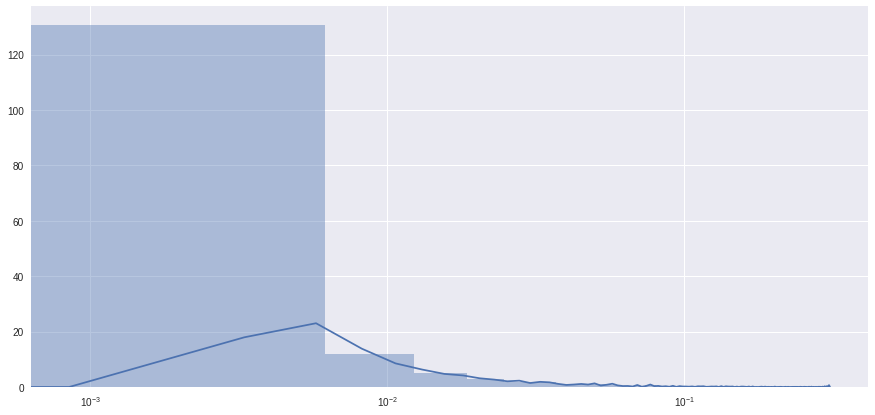

In [19]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(mses, ax=ax)
plt.show()

#### MSE loss

In [20]:
np.mean(mses)

0.0072440273088614452

#### Huber Loss

In [21]:
def huber_loss(y_true, y_pred):
    err = y_true - y_pred
    
    absolute = np.abs(err)
    
    ifthen = 0.5 * err
    ifelse = absolute - 0.5
    
    return np.where(absolute < 1.0, ifthen, ifelse)

In [22]:
huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    huber_losses[ii] = np.mean(huber_loss(pred, target))

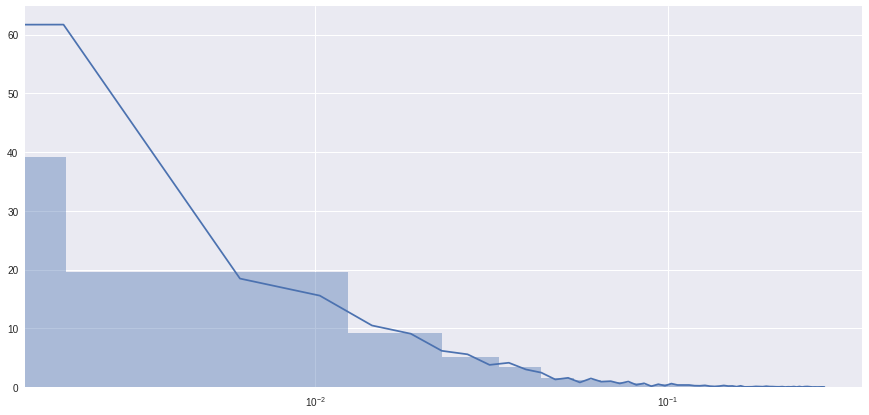

In [23]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(huber_losses, ax=ax)
plt.show()

In [24]:
np.mean(huber_losses)

0.0059580647553856315

In [25]:
targets.shape

(6400, 30)

In [26]:
%%time
dtw_scores = [fastdtw(targets[ind], preds[ind])[0]
              for ind in range(len(targets))]

CPU times: user 42.4 s, sys: 172 ms, total: 42.6 s
Wall time: 42.4 s


In [27]:
np.mean(dtw_scores)

1.141004411253415

In [43]:
from statsmodels.tsa.stattools import coint

In [47]:
coint(preds[0], targets[0])

(0.94655019010366148, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

### plots

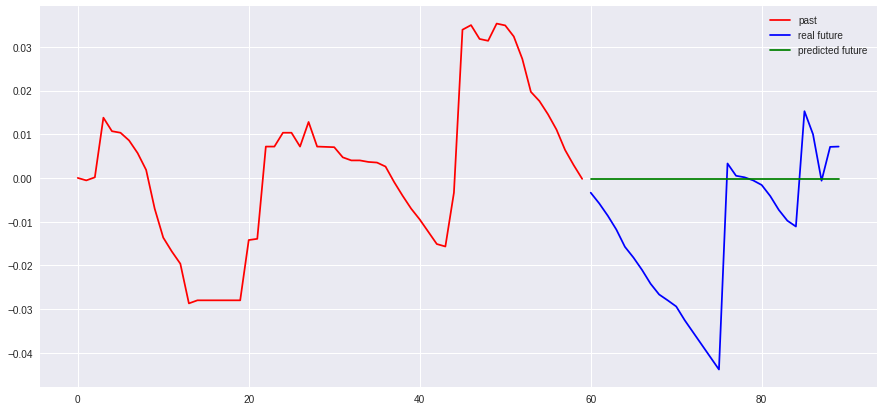

In [42]:
ind = np.random.randint(len(targets))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()

# Baseline is static, a straight line for each input (Global - Local norm)

In [49]:
data_path = '../data/price_history'

In [50]:
#npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'
#npz_path = data_path + '/price_history_03_dp_60to30_6400_global_remove_scale_train.npz'
npz_path = data_path + '/price_history_03_dp_60to30_6400_global_local_remove_scale_train.npz'

In [51]:
arr = np.load(npz_path)

In [52]:
arr.keys()

['inputs', 'sku_ids', 'sequence_masks', 'targets', 'sequence_lengths']

In [53]:
inputs = arr['inputs']
inputs.shape

(6400, 60, 1)

In [54]:
targets = arr['targets']
targets.shape

(6400, 30)

In [55]:
target_len = targets.shape[1]
target_len

30

In [56]:
preds = np.empty(shape=targets.shape + (1,))
preds.shape

(6400, 30, 1)

In [57]:
for ii, cur_in in enumerate(inputs):
    #print cur_in.shape
    #print cur_in[-1].shape
    preds[ii] = cur_in[-1]  #broadcasting
    #print np.repeat(cur_in[-1], target_len).shape
    #print np.repeat(cur_in[-1:], target_len)
    #print dummy_targets[ii].shape
    #print dummy_targets[ii]

### evaluate

In [58]:
data_len = len(inputs)
assert len(preds) == len(targets) and data_len == len(targets)

In [59]:
mses = np.empty(data_len)

In [60]:
from sklearn.metrics import mean_squared_error

In [61]:
mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    mses[ii] = mean_squared_error(pred, target)

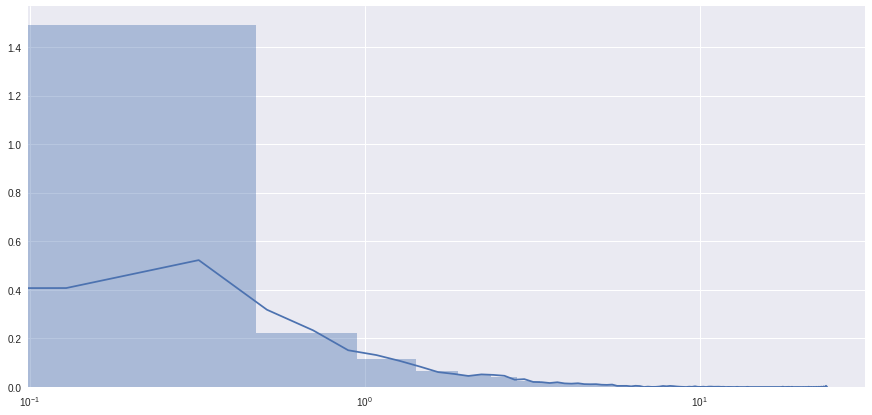

In [62]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(mses, ax=ax)
plt.show()

#### MSE loss

In [63]:
np.mean(mses)

0.64579170804784747

#### Huber Loss

In [64]:
def huber_loss(y_true, y_pred):
    err = y_true - y_pred
    
    absolute = np.abs(err)
    
    ifthen = 0.5 * err
    ifelse = absolute - 0.5
    
    return np.where(absolute < 1.0, ifthen, ifelse)

In [65]:
huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    huber_losses[ii] = np.mean(huber_loss(pred, target))

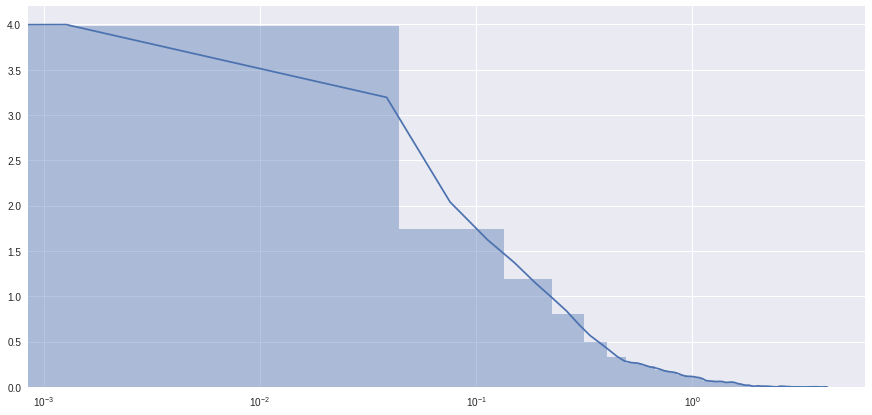

In [66]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(huber_losses, ax=ax)
plt.show()

In [67]:
np.mean(huber_losses)

0.22175774117878697

In [68]:
targets.shape

(6400, 30)

In [69]:
%%time
dtw_scores = [fastdtw(targets[ind], preds[ind])[0]
              for ind in range(len(targets))]

CPU times: user 42.7 s, sys: 152 ms, total: 42.8 s
Wall time: 42.6 s


In [70]:
np.mean(dtw_scores)

12.424643240525858

In [71]:
from statsmodels.tsa.stattools import coint

In [72]:
coint(preds[0], targets[0])

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(0.15280812391389967,
 0.98888427891250696,
 array([-4.31395736, -3.55493606, -3.19393252]))

### plots

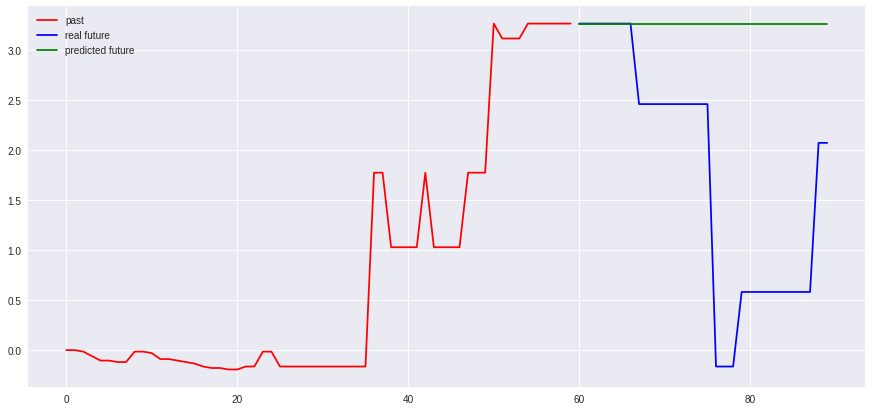

In [77]:
ind = np.random.randint(len(targets))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()